In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("=" * 80)
print("SOLVE4 CORRECTED — GCN vs GraphSAGE vs GAT")
print("BINARY CLASSIFICATION: Negative (0) vs Positive (1)")
print("Neutral reviews (sentiment_predicted == 0) are REMOVED")
print("=" * 80)

SOLVE4 CORRECTED — GCN vs GraphSAGE vs GAT
BINARY CLASSIFICATION: Negative (0) vs Positive (1)
Neutral reviews (sentiment_predicted == 0) are REMOVED


In [3]:
DF_PATH = "../data/tokenized/03_data_cleaned_full_tokens_final_score.csv"
df_original = pd.read_csv(DF_PATH)

print(f"Original dataset: {len(df_original):,} rows")

# Create a clean copy for binary classification
df = df_original.copy()

# CRITICAL FIX: Remove neutral sentiment (0) and map -1 to 0, 1 to 1
print("\nSentiment distribution BEFORE filtering:")
print(df["sentiment_predicted"].value_counts().sort_index())

# Filter out neutral reviews
df = df[df["sentiment_predicted"] != 0].copy()

print(f"\nAfter removing neutral reviews: {len(df):,} rows")
print("Sentiment distribution AFTER filtering:")
print(df["sentiment_predicted"].value_counts().sort_index())

# Map: -1 (negative) → 0, 1 (positive) → 1
df["sentiment_bin"] = df["sentiment_predicted"].map({-1: 0, 1: 1})

print("\nBinary sentiment distribution:")
print(df["sentiment_bin"].value_counts().sort_index())
print(f"  Class 0 (Negative): {(df['sentiment_bin'] == 0).sum():,} samples")
print(f"  Class 1 (Positive): {(df['sentiment_bin'] == 1).sum():,} samples")
print(f"  Class balance: {(df['sentiment_bin'] == 1).sum() / len(df) * 100:.2f}% positive")


Original dataset: 87,812 rows

Sentiment distribution BEFORE filtering:
sentiment_predicted
-1     8050
 0    10201
 1    69561
Name: count, dtype: int64

After removing neutral reviews: 77,611 rows
Sentiment distribution AFTER filtering:
sentiment_predicted
-1     8050
 1    69561
Name: count, dtype: int64

Binary sentiment distribution:
sentiment_bin
0     8050
1    69561
Name: count, dtype: int64
  Class 0 (Negative): 8,050 samples
  Class 1 (Positive): 69,561 samples
  Class balance: 89.63% positive


# STEP 2: NODE INDEXING

In [4]:

users = df["user_id"].unique()
hotels = df["hotel_id"].unique()

user2id = {u: i for i, u in enumerate(users)}
hotel2id = {h: i + len(users) for i, h in enumerate(hotels)}

num_nodes = len(users) + len(hotels)
print(f"\nNodes: {num_nodes:,} ({len(users):,} users + {len(hotels):,} hotels)")



Nodes: 22,529 (22,221 users + 308 hotels)


# STEP 3: ENHANCED NODE FEATURES

In [5]:

print("\nBuilding node features...")

# ---------- USER FEATURES (EXPANDED) ----------
user_df = df.groupby("user_id").agg(
    rating_mean=("rating", "mean"),
    rating_std=("rating", "std"),
    rating_min=("rating", "min"),
    rating_max=("rating", "max"),
    review_count=("rating", "count"),
    sentiment_mean=("sentiment_bin", "mean"),
    sentiment_std=("sentiment_bin", "std"),
    camelbert_mean=("camelbert_sentiment_score", "mean"),
    camelbert_std=("camelbert_sentiment_score", "std"),
).fillna(0)

# ---------- HOTEL FEATURES (EXPANDED) ----------
hotel_df = df.groupby("hotel_id").agg(
    rating_mean=("rating", "mean"),
    rating_std=("rating", "std"),
    rating_min=("rating", "min"),
    rating_max=("rating", "max"),
    review_count=("rating", "count"),
    hotel_rating=("hotel_rating", "first"),
    price=("price_dzd", "first"),
    distance=("distance_center_km", "first"),
    sentiment_mean=("sentiment_bin", "mean"),
    sentiment_std=("sentiment_bin", "std"),
).fillna(0)


Building node features...


In [6]:
# Log transform for skewed features
for feat in ["review_count", "price", "distance"]:
    if feat in user_df.columns:
        user_df[feat] = np.log1p(user_df[feat])
    if feat in hotel_df.columns:
        hotel_df[feat] = np.log1p(hotel_df[feat])

sc_user = StandardScaler()
sc_hotel = StandardScaler()

user_x = torch.tensor(sc_user.fit_transform(user_df), dtype=torch.float)
hotel_x = torch.tensor(sc_hotel.fit_transform(hotel_df), dtype=torch.float)

# Pad to same dimension
dim = max(user_x.shape[1], hotel_x.shape[1])
user_x = F.pad(user_x, (0, dim - user_x.shape[1]))
hotel_x = F.pad(hotel_x, (0, dim - hotel_x.shape[1]))

x = torch.cat([user_x, hotel_x], dim=0)

print(f"Node feature dimension: {x.shape[1]}")

Node feature dimension: 10


# STEP 4: EDGES

In [7]:

print("Building edges...")

edges = []
labels = []

for _, r in df.iterrows():
    u = user2id[r.user_id]
    h = hotel2id[r.hotel_id]
    y = r.sentiment_bin

    edges.append([u, h])
    edges.append([h, u])
    labels.extend([y, y])

edge_index = torch.tensor(edges, dtype=torch.long).t()
edge_labels = torch.tensor(labels, dtype=torch.long)

print(f"Total edges: {edge_index.shape[1]:,} (bidirectional)")


Building edges...
Total edges: 155,222 (bidirectional)


# STEP 5: TRAIN / VAL / TEST SPLIT

In [8]:

print("\nSplitting data...")

num_edges = edge_index.shape[1] // 2
perm = torch.randperm(num_edges)

train_n = int(0.6 * num_edges)
val_n = int(0.2 * num_edges)

train_mask = torch.zeros(num_edges, dtype=torch.bool)
val_mask = torch.zeros(num_edges, dtype=torch.bool)
test_mask = torch.zeros(num_edges, dtype=torch.bool)

train_mask[perm[:train_n]] = True
val_mask[perm[train_n:train_n + val_n]] = True
test_mask[perm[train_n + val_n:]] = True

print(f"Train edges: {train_mask.sum():,}")
print(f"Val edges: {val_mask.sum():,}")
print(f"Test edges: {test_mask.sum():,}")

graph_data = Data(x=x, edge_index=edge_index, y=edge_labels).to(DEVICE)
train_mask = train_mask.to(DEVICE)
val_mask = val_mask.to(DEVICE)
test_mask = test_mask.to(DEVICE)

print("Graph ready\n")


Splitting data...
Train edges: 46,566
Val edges: 15,522
Test edges: 15,523
Graph ready



# STEP 6: ENHANCED EDGE GNN WITH RESIDUAL CONNECTIONS

In [9]:
class EdgeGNN(nn.Module):
    def __init__(self, gnn, in_dim, hidden, layers, dropout):
        super().__init__()
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.skip_connections = nn.ModuleList()

        for i in range(layers):
            ic = in_dim if i == 0 else hidden
            if gnn == "GCN":
                conv = GCNConv(ic, hidden)
            elif gnn == "SAGE":
                conv = SAGEConv(ic, hidden)
            elif gnn == "GAT":
                conv = GATConv(ic, hidden // 4, heads=4, concat=True)
            self.convs.append(conv)
            self.bns.append(nn.BatchNorm1d(hidden))
            
            # Skip connection for residual learning
            if i > 0:
                self.skip_connections.append(nn.Linear(hidden, hidden))

        # Enhanced edge MLP with more layers
        self.edge_mlp = nn.Sequential(
            nn.Linear(hidden * 2, hidden * 2),
            nn.BatchNorm1d(hidden * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden * 2, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 2)
        )
        self.dropout = dropout

    def forward(self, x, edge_index):
        for i, (c, b) in enumerate(zip(self.convs, self.bns)):
            x_new = c(x, edge_index)
            x_new = b(x_new)
            x_new = F.relu(x_new)
            x_new = F.dropout(x_new, p=self.dropout, training=self.training)
            
            # Add residual connection after first layer
            if i > 0:
                x = x + self.skip_connections[i-1](x_new)
            else:
                x = x_new
        return x

    def predict(self, z, s, d):
        return self.edge_mlp(torch.cat([z[s], z[d]], dim=1))


# STEP 7: TRAIN & EVAL WITH DETAILED LOGGING

In [10]:
def train_epoch(model, opt):
    model.train()
    opt.zero_grad()
    z = model(graph_data.x, graph_data.edge_index)
    idx = torch.where(train_mask)[0]
    s = graph_data.edge_index[0, idx * 2]
    d = graph_data.edge_index[1, idx * 2]
    y = graph_data.y[idx * 2]
    
    logits = model.predict(z, s, d)
    loss = F.cross_entropy(logits, y)
    
    # Calculate training accuracy
    with torch.no_grad():
        pred = logits.argmax(1)
        train_acc = accuracy_score(y.cpu(), pred.cpu())
    
    loss.backward()
    opt.step()
    return loss.item(), train_acc

@torch.no_grad()
def eval_model(model, mask):
    model.eval()
    z = model(graph_data.x, graph_data.edge_index)
    idx = torch.where(mask)[0]
    s = graph_data.edge_index[0, idx * 2]
    d = graph_data.edge_index[1, idx * 2]
    y = graph_data.y[idx * 2]
    logits = model.predict(z, s, d)
    p = logits.argmax(1)
    prob = F.softmax(logits, 1)[:, 1]
    return {
        "acc": accuracy_score(y.cpu(), p.cpu()),
        "prec": precision_score(y.cpu(), p.cpu(), zero_division=0),
        "rec": recall_score(y.cpu(), p.cpu(), zero_division=0),
        "f1": f1_score(y.cpu(), p.cpu(), zero_division=0),
        "auc": roc_auc_score(y.cpu(), prob.cpu())
    }

# STEP 8: RUN ALL MODELS WITH ENHANCED SETTINGS

In [11]:
results = {}
training_history = {}  # Store training history for plotting
HIDDEN = 512
LAYERS = 5
LR = 0.001
EPOCHS = 13

for gnn in ["GCN", "SAGE", "GAT"]:
    print("=" * 70)
    print(f"Training {gnn}")
    print("=" * 70)

    model = EdgeGNN(
        gnn, graph_data.num_node_features,
        HIDDEN, LAYERS, 0.3
    ).to(DEVICE)

    opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode='max', factor=0.5, patience=15
    )
    
    best_f1 = 0
    best_state = None
    patience_counter = 0
    
    # Initialize history tracking
    history = {
        'epoch': [],
        'train_loss': [],
        'train_acc': [],
        'val_acc': [],
        'val_prec': [],
        'val_rec': [],
        'val_f1': [],
        'val_auc': []
    }
    
    print(f"{'Epoch':<8}{'Loss':<10}{'Train Acc':<12}{'Val Acc':<10}{'Val F1':<10}")
    print("-" * 60)

    for ep in range(EPOCHS):
        loss, train_acc = train_epoch(model, opt)
        val = eval_model(model, val_mask)
        
        # Store metrics in history
        history['epoch'].append(ep + 1)
        history['train_loss'].append(loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val['acc'])
        history['val_prec'].append(val['prec'])
        history['val_rec'].append(val['rec'])
        history['val_f1'].append(val['f1'])
        history['val_auc'].append(val['auc'])
        
        # Learning rate scheduling
        scheduler.step(val["f1"])
        
        if val["f1"] > best_f1:
            best_f1 = val["f1"]
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Print every epoch
        print(f"{ep+1:<8}{loss:<10.4f}{train_acc:<12.4f}{val['acc']:<10.4f}{val['f1']:<10.4f}")
        
        # Early stopping
        if patience_counter >= 30:
            print(f"Early stopping at epoch {ep+1}")
            break

    model.load_state_dict(best_state)
    results[gnn] = eval_model(model, test_mask)
    training_history[gnn] = history
    torch.save(best_state, f"best_{gnn}_solve4_corrected.pt")
  

Training GCN
Epoch   Loss      Train Acc   Val Acc   Val F1    
------------------------------------------------------------
1       0.8581    0.3761      0.8189    0.8986    
2       1.4576    0.3692      0.1086    0.0000    
3       0.6604    0.6329      0.8409    0.9128    
4       0.5051    0.8282      0.8914    0.9426    
5       0.4238    0.8691      0.8914    0.9426    
6       0.3867    0.8759      0.8914    0.9426    
7       0.3499    0.8956      0.8434    0.9145    
8       0.3481    0.8981      0.5227    0.6656    
9       0.3452    0.8982      0.4425    0.5794    
10      0.3464    0.8982      0.4256    0.5603    
11      0.3495    0.8981      0.5189    0.6629    
12      0.3566    0.8981      0.7862    0.8785    
13      0.3604    0.8982      0.8914    0.9426    
Training SAGE
Epoch   Loss      Train Acc   Val Acc   Val F1    
------------------------------------------------------------
1       0.8103    0.3786      0.1111    0.0059    
2       0.7532    0.7007      0.891

# FINAL COMPARISON

FINAL TEST RESULTS (Binary: Negative vs Positive, Neutrals Removed)
Model   Acc       Prec      Rec       F1        AUC       
------------------------------------------------------------
GCN     0.8953    0.8953    1.0000    0.9448    0.4671    
SAGE    0.8221    0.8989    0.9029    0.9009    0.5855    
GAT     0.5783    0.9005    0.5947    0.7163    0.5215    

GENERATING TRAINING VISUALIZATIONS


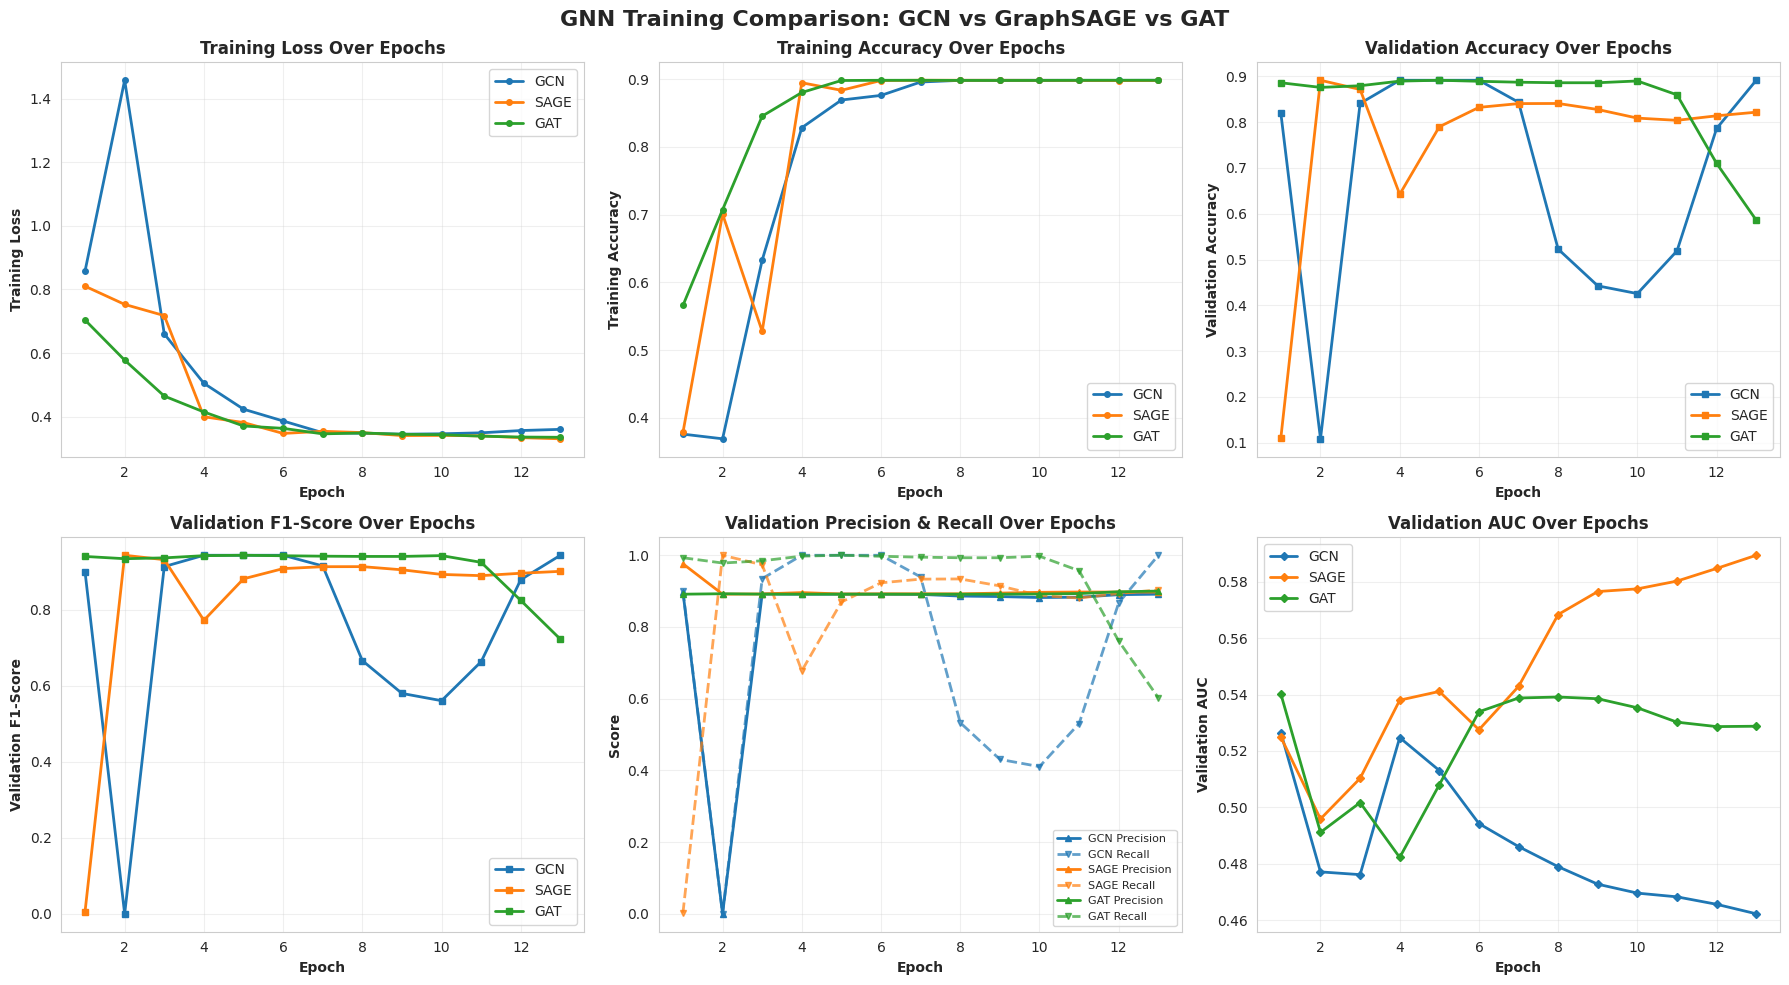

In [18]:
print("=" * 80)
print("FINAL TEST RESULTS (Binary: Negative vs Positive, Neutrals Removed)")
print("=" * 80)
print(f"{'Model':<8}{'Acc':<10}{'Prec':<10}{'Rec':<10}{'F1':<10}{'AUC':<10}")
print("-" * 60)
for k, v in results.items():
    print(f"{k:<8}{v['acc']:<10.4f}{v['prec']:<10.4f}{v['rec']:<10.4f}{v['f1']:<10.4f}{v['auc']:<10.4f}")

# ============================================================
# VISUALIZATION: TRAINING CURVES
# ============================================================

print("\n" + "=" * 80)
print("GENERATING TRAINING VISUALIZATIONS")
print("=" * 80)

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('GNN Training Comparison: GCN vs GraphSAGE vs GAT', fontsize=16, fontweight='bold')

colors = {'GCN': '#1f77b4', 'SAGE': '#ff7f0e', 'GAT': '#2ca02c'}

# Plot 1: Training Loss
ax = axes[0, 0]
for gnn, history in training_history.items():
    ax.plot(history['epoch'], history['train_loss'], 
            marker='o', label=gnn, color=colors[gnn], linewidth=2, markersize=4)
ax.set_xlabel('Epoch', fontweight='bold')
ax.set_ylabel('Training Loss', fontweight='bold')
ax.set_title('Training Loss Over Epochs', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Training Accuracy
ax = axes[0, 1]
for gnn, history in training_history.items():
    ax.plot(history['epoch'], history['train_acc'], 
            marker='o', label=gnn, color=colors[gnn], linewidth=2, markersize=4)
ax.set_xlabel('Epoch', fontweight='bold')
ax.set_ylabel('Training Accuracy', fontweight='bold')
ax.set_title('Training Accuracy Over Epochs', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Validation Accuracy
ax = axes[0, 2]
for gnn, history in training_history.items():
    ax.plot(history['epoch'], history['val_acc'], 
            marker='s', label=gnn, color=colors[gnn], linewidth=2, markersize=4)
ax.set_xlabel('Epoch', fontweight='bold')
ax.set_ylabel('Validation Accuracy', fontweight='bold')
ax.set_title('Validation Accuracy Over Epochs', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Validation F1-Score
ax = axes[1, 0]
for gnn, history in training_history.items():
    ax.plot(history['epoch'], history['val_f1'], 
            marker='s', label=gnn, color=colors[gnn], linewidth=2, markersize=4)
ax.set_xlabel('Epoch', fontweight='bold')
ax.set_ylabel('Validation F1-Score', fontweight='bold')
ax.set_title('Validation F1-Score Over Epochs', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 5: Validation Precision & Recall
ax = axes[1, 1]
for gnn, history in training_history.items():
    ax.plot(history['epoch'], history['val_prec'], 
            marker='^', label=f'{gnn} Precision', color=colors[gnn], 
            linewidth=2, markersize=4, linestyle='-')
    ax.plot(history['epoch'], history['val_rec'], 
            marker='v', label=f'{gnn} Recall', color=colors[gnn], 
            linewidth=2, markersize=4, linestyle='--', alpha=0.7)
ax.set_xlabel('Epoch', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Validation Precision & Recall Over Epochs', fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 6: Validation AUC
ax = axes[1, 2]
for gnn, history in training_history.items():
    ax.plot(history['epoch'], history['val_auc'], 
            marker='D', label=gnn, color=colors[gnn], linewidth=2, markersize=4)
ax.set_xlabel('Epoch', fontweight='bold')
ax.set_ylabel('Validation AUC', fontweight='bold')
ax.set_title('Validation AUC Over Epochs', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# VISUALIZATION: TEST SET PERFORMANCE COMPARISON

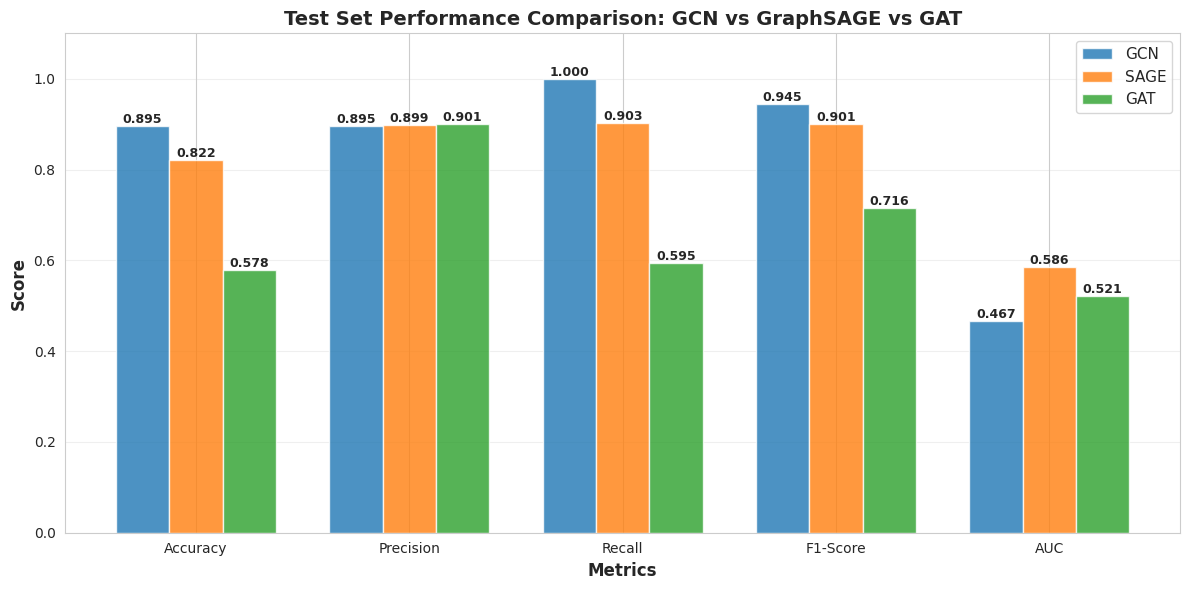

In [17]:
# Bar chart comparing all models on test set
fig, ax = plt.subplots(figsize=(12, 6))

metrics = ['acc', 'prec', 'rec', 'f1', 'auc']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
x = np.arange(len(metrics))
width = 0.25

for i, (gnn, color) in enumerate(colors.items()):
    values = [results[gnn][m] for m in metrics]
    offset = (i - 1) * width
    bars = ax.bar(x + offset, values, width, label=gnn, color=color, alpha=0.8)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Metrics', fontweight='bold', fontsize=12)
ax.set_ylabel('Score', fontweight='bold', fontsize=12)
ax.set_title('Test Set Performance Comparison: GCN vs GraphSAGE vs GAT', 
             fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.legend(fontsize=11)
ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# VISUALIZATION: BEST MODEL IDENTIFICATION

✓ Saved: performance_heatmap.png


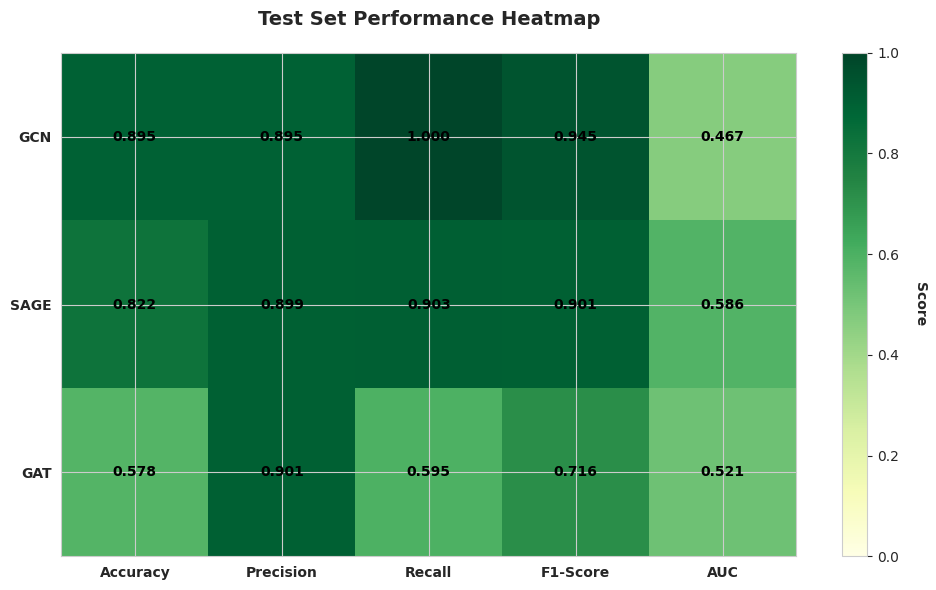

In [16]:
# Heatmap showing which model performs best on each metric
fig, ax = plt.subplots(figsize=(10, 6))

# Create matrix of test results
test_matrix = []
model_names = list(results.keys())
for gnn in model_names:
    test_matrix.append([results[gnn][m] for m in metrics])

test_matrix = np.array(test_matrix)

# Create heatmap
im = ax.imshow(test_matrix, cmap='YlGn', aspect='auto', vmin=0, vmax=1)

# Set ticks and labels
ax.set_xticks(np.arange(len(metric_names)))
ax.set_yticks(np.arange(len(model_names)))
ax.set_xticklabels(metric_names, fontweight='bold')
ax.set_yticklabels(model_names, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Score', rotation=270, labelpad=20, fontweight='bold')

# Add text annotations
for i in range(len(model_names)):
    for j in range(len(metrics)):
        text = ax.text(j, i, f'{test_matrix[i, j]:.3f}',
                      ha="center", va="center", color="black", fontweight='bold')

ax.set_title('Test Set Performance Heatmap', fontweight='bold', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('performance_heatmap.png', dpi=300, bbox_inches='tight')
print("✓ Saved: performance_heatmap.png")
plt.show()


# VISUALIZATION: LEARNING EFFICIENCY

In [15]:
# Plot showing convergence speed (epochs to reach 90% of best performance)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: F1 convergence
ax = axes[0]
for gnn, history in training_history.items():
    epochs = history['epoch']
    f1_scores = history['val_f1']
    best_f1 = max(f1_scores)
    threshold_90 = 0.9 * best_f1
    
    ax.plot(epochs, f1_scores, marker='o', label=gnn, 
            color=colors[gnn], linewidth=2, markersize=5)
    ax.axhline(y=threshold_90, color=colors[gnn], linestyle='--', alpha=0.3)

ax.set_xlabel('Epoch', fontweight='bold')
ax.set_ylabel('Validation F1-Score', fontweight='bold')
ax.set_title('F1-Score Convergence Speed', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Right: Loss convergence
ax = axes[1]
for gnn, history in training_history.items():
    ax.plot(history['epoch'], history['train_loss'], 
            marker='o', label=gnn, color=colors[gnn], linewidth=2, markersize=5)

ax.set_xlabel('Epoch', fontweight='bold')
ax.set_ylabel('Training Loss', fontweight='bold')
ax.set_title('Training Loss Convergence', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('convergence_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: convergence_analysis.png")
plt.close()

print("\n" + "=" * 80)
print("All visualizations saved successfully!")
print("=" * 80)

print("\n✓ solve4_corrected_binary.py finished")
print("\nKey improvements in this version:")
print("  - Removed neutral sentiment (0) for cleaner binary classification")
print("  - Properly mapped: -1 → 0 (negative), 1 → 1 (positive)")
print("  - This should significantly improve model performance and interpretability")
print("\nGenerated plots:")
print("  1. training_curves_comparison.png - Training metrics over epochs")
print("  2. test_performance_comparison.png - Final test results comparison")
print("  3. performance_heatmap.png - Heatmap of all metrics")
print("  4. convergence_analysis.png - Learning efficiency analysis")

✓ Saved: convergence_analysis.png

All visualizations saved successfully!

✓ solve4_corrected_binary.py finished

Key improvements in this version:
  - Removed neutral sentiment (0) for cleaner binary classification
  - Properly mapped: -1 → 0 (negative), 1 → 1 (positive)
  - This should significantly improve model performance and interpretability

Generated plots:
  1. training_curves_comparison.png - Training metrics over epochs
  2. test_performance_comparison.png - Final test results comparison
  3. performance_heatmap.png - Heatmap of all metrics
  4. convergence_analysis.png - Learning efficiency analysis
